In [7]:
pip install -q pyprind

Note: you may need to restart the kernel to use updated packages.


## Lista 1 - Regressão linear, polinomial e regularização

In [9]:
import pyprind # Deixa o print mais bonito na etapa de treinamento
import numpy as np
import matplotlib.pyplot as plt
from typing      import TypedDict

RMSE

In [10]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

Criando modelo

In [11]:
# Classe de paramentros para GD e SG
class Parametros(TypedDict):
    callable

`Gradiente Descente`

In [12]:
class RegressaoLinearGD:
    def __init__(self, **parametros: Parametros):
        x = parametros['x']

        self.x = np.c_[np.ones((x.shape[0], 1)), x]
        self.y = parametros['y']
        self.regularizao = parametros['regularizao']
        self.alpha  = parametros['alpha']
        self.lr     = parametros['lr']
        self.epochs = parametros['epochs']
        self.lista_processo = [] if parametros['salvar_processo'] else None
        self.loss = parametros['loss']

        # Inicializa os parametros aleatoriamente
        self.params = np.random.randn(self.x.shape[1], 1).astype(np.float32)

    def reguraliza(self, coeficientes):
        match self.regularizao:
            case 'l2': return 2 * self.alpha * coeficientes
            case 'l1': return self.alpha * np.sign(coeficientes)
            case _: return 0

    def ajusta(self):
        # Deixando o print mais bonito na etapa de treinamento
        bar = pyprind.ProgBar(self.epochs)

        N = self.x.shape[0]
        for epoch in range(self.epochs):
            pred = np.dot(self.x, self.params)

            # Atualizando os coeficientes = coeficientes - lr * gradiente
            self.params = self.params - self.lr *  ((1/N) * (self.x.T @ (pred - self.y)) + self.reguraliza(self.params))

            bar.update(1, item_id=f'Epoca {epoch+1} - perda {self.loss(self.y, pred)}')

            if self.lista_processo is not None:
                self.lista_processo.append(self.loss(self.y, pred))

        return self

    def predicao(self, x):
        x_ = np.c_[np.ones((x.shape[0], 1)), x]
        return np.dot(x_, self.params)

`Gradiente Descendente Estocastico`

In [13]:
class RegressaoLinearSGD:
    def __init__(self, **parametros: Parametros):
        x = parametros['x']

        self.x = np.c_[np.ones((x.shape[0], 1)), x]
        self.y = parametros['y']
        self.regularizao = parametros['regularizao']
        self.alpha  = parametros['alpha']
        self.lr     = parametros['lr']
        self.epochs = parametros['epochs']
        self.salvar_processo = [] if parametros['salvar_processo'] else None
        self.loss = parametros['loss']

        # Inicializa os coeficientes aleatoriamente
        self.params = np.random.randn(self.x.shape[1], 1).astype(np.float32)

    def reguraliza(self, coeficientes):
        match self.regularizao:
            case 'l2': return 2 * self.alpha * coeficientes
            case 'l1': return self.alpha * np.sign(coeficientes)
            case _: return 0

    def ajusta(self):
        # Deixando o print mais bonito na etapa de treinamento
        bar = pyprind.ProgBar(self.epochs)

        index = np.arange(self.x.shape[0])

        N = self.x.shape[0]

        for epoch in range(self.epochs):
            index_random = np.random.permutation(index) # Embaralha os indices
            for i in index_random:
                xi = self.x[i, :].reshape(1, -1)
                yi = self.y[i].reshape(1, -1)

                y_pred = np.dot(xi, self.params)

                self.params = self.params - self.lr * (xi.T @ (y_pred - yi) + self.reguraliza(self.params))

            bar.update(1, item_id=f'Epoca {epoch+1} - perda {self.loss(self.y, y_pred)}')

            if self.salvar_processo is not None:
                self.salvar_processo.append(self.loss(self.y, y_pred))
        return self

    def predicao(self, x):
        # Adicionado a coluna do inteceptor
        x_ = np.c_[np.ones((x.shape[0], 1)), x]

        return np.dot(x_, self.params)

`Ols`

In [14]:
class RegressaoLinearOLS:
    def __init__(self, X, y, alpha=None):
        self.X = X
        self.y = y
        self.coeficientes = None
        self.alpha = alpha

    def ajusta(self):
        # Adiciona uma coluna de 1s para o termo de interceptor
        X_ = np.c_[np.ones((self.X.shape[0], 1)), self.X]

        # Cálculo dos coeficientes usando a fórmula dos mínimos quadrados
        if self.alpha is None:
            self.coeficientes = np.linalg.inv(X_.T @ X_) @ X_.T @ self.y
        else:
            self.self.coeficientes = np.linalg.inv(X_.T @ X_ + self.alpha * np.identity(X_.shape[1])) @ X_.T @ self.y

        return self
    def predicao(self, X):
        X_ = np.c_[np.ones((X.shape[0], 1)), X]
        return X_ @ self.coeficientes

In [189]:
np.identity(2)

array([[1., 0.],
       [0., 1.]])

`Normalizacao`

In [190]:
class Normalizacao:
    def __init__(self, X):
        # Inicializa os atributos
        self.desvios_padroes = None
        self.medias          = None
        self.x = X
        self.size = self.x.shape[1]

    # Função para calcular a média de cada coluna
    def mean_(self):
        # Verificando a quantidade de colunas


        # Calcula a média de cada coluna
        self.medias = np.array(
            [ np.around(np.mean(self.x[:, i]), 2) for i in range(self.size)]
        )

        # Retorna o próprio objeto
        return self

    def std_(self):
        # Calcula a média
        self.mean_()

        # Calcula o desvio padrão de cada coluna
        self.desvios_padroes = np.array([
            np.sqrt(np.mean( (self.x[:, i] - self.medias[i])**2) ) for i in range(self.size)
        ])
        return self

    def transformacao(self):
        # Chamando funções para calcular média e desvio padrão
        self.std_()

        # Aplica a normalização z-score
        for i in range(self.x.shape[1]):
            self.x[:, i] = (self.x[:, i] - self.medias[i]) / self.desvios_padroes[i]
        return self.x

    def inversa_transformacao(self, x):
        try:
            x = np.multiply(self.desvios_padroes, x) + self.medias
        except Exception as e:
            print("talvez você não normalizou os dados ainda", e)
        return x

`MinMax`

In [191]:
class MinMax:
    def __init__(self, X):
        self.x = X
        self.min_ = self.x.min(axis=0)
        self.max_ = self.x.max(axis=0)

    def transformacao(self):
        return (self.x - self.min_) / (self.max_ - self.min_)

    def inversa_transformacao(self, x):
        try:
            x = x * (self.max_ - self.min_) + self.min_
        except Exception as e:
            print("talvez você não normalizou os dados ainda", e)
        return x

&nbsp;

&nbsp;

----------------

# Questão 1

In [192]:
data = np.loadtxt('./artificial1d.csv', delimiter=',')

In [193]:
data[:5, :]

array([[-1.        , -2.08201726],
       [-0.93103448, -1.32698023],
       [-0.86206897, -1.10559772],
       [-0.79310345, -0.87394576],
       [-0.72413793, -0.28502695]])

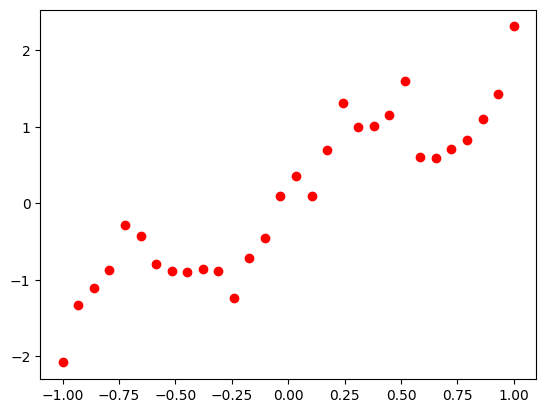

In [194]:
plt.plot(data[:, 0], data[:, 1], 'ro')
plt.show()

In [195]:
x = data[:, 0].reshape(-1, 1)
y = data[:, 1].reshape(-1, 1)

a. Apresente os parâmetros do modelo e o MSE (erro quadrático médio) obtidos pelo algoritmo OLS (mínimos quadrados ordinários). Plote a reta resultante sobre os dados.

In [196]:
ols = RegressaoLinearOLS(x, y)
ols.ajusta()

Parametros

In [197]:
ols.coeficientes

array([[0.06761792],
       [1.57486517]])

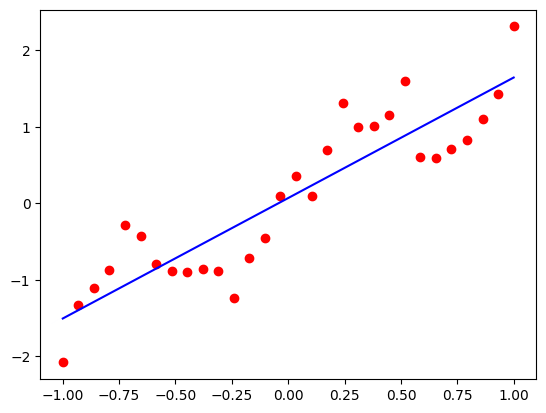

In [198]:
plt.plot(x, y, 'ro')
plt.plot(x, ols.predicao(x), 'b')
plt.show()

In [199]:
MSE(y, ols.predicao(x))

np.float64(0.21340090132936987)

b.Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem obtidos pelo algoritmo GD (gradiente descendente). Plote a reta resultante sobre os dados.

In [200]:
gd = RegressaoLinearGD(
    x = x,
    y = y,
    regularizao = 'l2',
    alpha = 0,
    lr = 0.001,
    epochs = 1000,
    salvar_processo = True,
    loss = MSE
)
print(gd.params)
gd.ajusta()

[[ 0.04771962]
 [-0.4093023 ]]


0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 1000 - perda 0.9017204678336219
Total time elapsed: 00:00:00


In [201]:
gd.params

array([[0.06030141],
       [0.18554565]])

Curva de aprendizagem

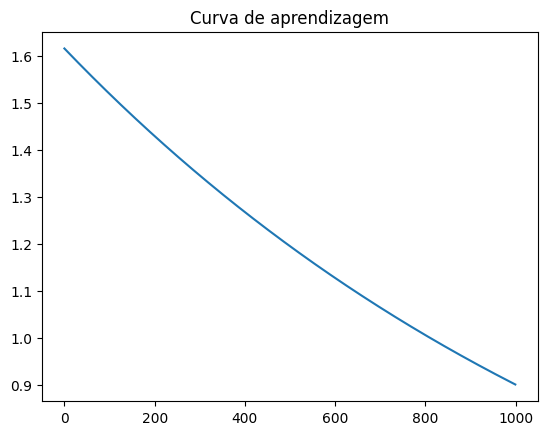

In [202]:
plt.plot(gd.lista_processo)
plt.title('Curva de aprendizagem')
plt.show()

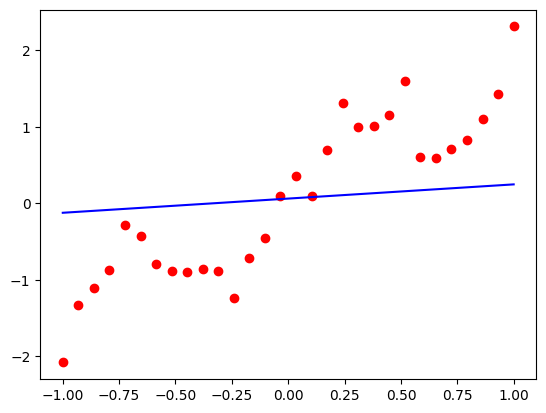

In [203]:
plt.plot(x, y, 'ro')
plt.plot(x, gd.predicao(x), 'b')
plt.show()

In [204]:
MSE(y, gd.predicao(x))

np.float64(0.9012299596334483)

c. Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem obtidos pelo algoritmo SGD (gradiente descendente estocástico). Plote a reta resultante sobre os dados.

In [205]:
sgd = RegressaoLinearSGD(
    x = x,
    y = y,
    regularizao = None,
    alpha = 1,
    lr = 0.01,
    epochs = 1000,
    salvar_processo = True,
    loss = MSE
)
sgd.ajusta()

0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 1000 - perda 1.122579369712431
Total time elapsed: 00:00:00


In [206]:
sgd.params

array([[0.06749485],
       [1.57549034]])

Curva de aprendizagem

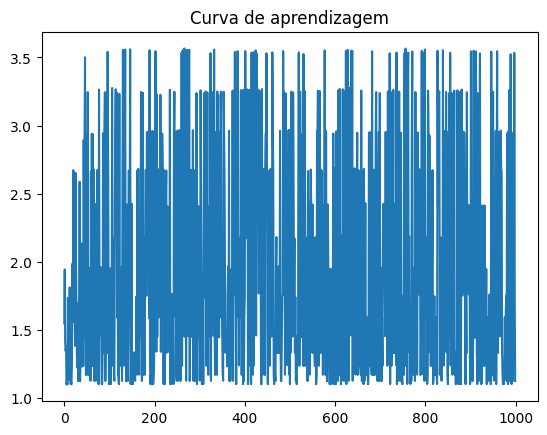

In [207]:
plt.plot(sgd.salvar_processo)
plt.title("Curva de aprendizagem")
plt.show()

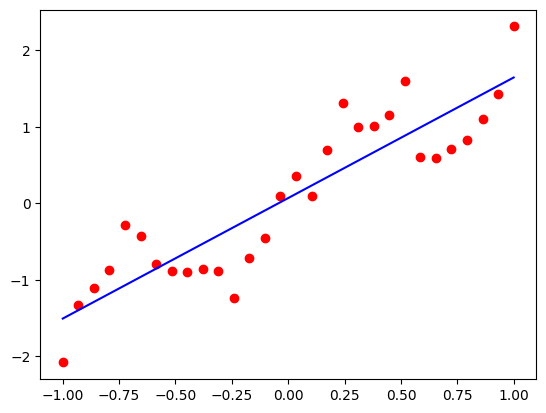

In [208]:
plt.plot(x, y, 'ro')
plt.plot(x, sgd.predicao(x), 'b')
plt.show()

MSE

In [209]:
MSE(y, sgd.predicao(x))

np.float64(0.2134010557410321)

Resultado final

In [210]:
print(f'''
OLS : MSE = {MSE(y, ols.predicao(x)):.3f}
GD  : MSE = {MSE(y, gd.predicao(x)):.3f}
SGD : MSE = {MSE(y, sgd.predicao(x)):.3f}
''')


OLS : MSE = 0.213
GD  : MSE = 0.901
SGD : MSE = 0.213



&nbsp;

-----------------

# Questão 2

Nota: Normalize os dados (a saída com StandardScaler e as entradas com MinMax) antes do treinamento/teste (antes de criar os regressores polinomiais) e “desnormalize” a saída antes de calcular o RMSE

In [211]:
data = np.loadtxt('./california.csv', delimiter=',')
data[:1, :].tolist()

[[4.1685,
  20.0,
  6.7006369426751595,
  1.178343949044586,
  745.0,
  2.372611464968153,
  38.8,
  -121.15,
  2.175]]

In [212]:
x = data[:, 0:8].astype(np.float32)
y = data[:, 8].reshape(-1, 1).astype(np.float32)

Saidas StandardScaler

In [213]:
y[0,:]

array([2.175], dtype=float32)

In [214]:
saida_ss = Normalizacao(y)
y_ss = saida_ss.transformacao()

Entradas MinMax

In [215]:
entradas_mm = MinMax(x)
x_mm = entradas_mm.transformacao()

a. Aleatoriamente, divida o conjunto de dados em treino (80%) e teste (20%).


In [216]:
def train_test(X, y, test_size = 0.2, seed=1):
    rnd = np.random.RandomState(seed)

    index = np.arange(X.shape[0])
    rnd.shuffle(index)
    test_index = index[:int(X.shape[0] * test_size)]
    train_index = index[int(X.shape[0] * test_size):]

    xtest = X[test_index]
    ytest = y[test_index]

    xtrain = X[train_index]
    ytrain = y[train_index]

    return xtrain, ytrain, xtest, ytest

In [217]:
xtrain, ytrain, xtest, ytest = train_test(x_mm, y_ss)

b. Treine 13 modelos de regressão polinomial, com ordens de 1 a 13. Você pode usar o algoritmo OLS.


In [218]:
from itertools import combinations_with_replacement
def polinomial(x, ordems=13):
    l, c = x.shape
    features = []

    # Para cada grau será feito a poly
    for grau in range(1, ordems+1):
        # Combinações de colunas com repetição
        combinacoes = combinations_with_replacement(range(c), grau)

        for comb in combinacoes:
            # produto das features escolhidas
            prod = np.ones(l)
            for i in comb:
                prod *= x[:, i]
            features.append(prod.reshape(-1, 1))

    # Concatena todas as colunas
    new_x = np.hstack(features)
    return new_x

In [219]:
import time

In [220]:
inicio = time.time()

with open('result.txt', 'w') as f:
    #f.write('tipo,rmse,ordem,coeficientes\n')
    for i in range(1, 9):
        xtrain_p = polinomial(xtrain, i)
        xtest_p = polinomial(xtest, i)
        ols = RegressaoLinearOLS(xtrain_p, ytrain)
        ols.ajusta()

        pred_test   = ols.predicao(xtest_p)
        pred_train  = ols.predicao(xtrain_p)

        inv_ytest = saida_ss.inversa_transformacao(ytest)
        inv_ytrain = saida_ss.inversa_transformacao(ytrain)

        inv_pred_test = saida_ss.inversa_transformacao(pred_test)
        inv_pred_train = saida_ss.inversa_transformacao(pred_train)

        RMSE_test = RMSE(inv_ytest, inv_pred_test)
        RMSE_train = RMSE(inv_ytrain, inv_pred_train)

        len_coef = len(ols.coeficientes)
        f.write(
            'test,' +str(round(RMSE_test,3)) +','+str(i)+','+str(len_coef)+'\n'
        )
        f.write(
            'train,'+str(round(RMSE_train,3)) +','+str(i)+','+str(len_coef)+'\n'
        )
final = time.time()
print(f'Tempo de execução: {final - inicio}')

Tempo de execução: 174.88398218154907


> Devido ao estouro de melhoria so consegui até ordem 8

c. Reporte o RMSE (raiz quadrada do erro quadrático médio) no treinamento e no teste para cada modelo. Faça um gráfico para o treino e um gráfico para o teste.


In [221]:
# Definindo o tipo de cada coluna para leitura no numpy
dtypes = np.dtype([
    ('tipo', 'U5'),
    ('rmse', np.float32),
    ('ordem', np.int32),
    ('coeficientes', np.int32)
])
dtypes

dtype([('tipo', '<U5'), ('rmse', '<f4'), ('ordem', '<i4'), ('coeficientes', '<i4')])

In [222]:
# Lendo o resultado.txt
sub = np.loadtxt('result.txt', delimiter=',', dtype=dtypes)
sub

array([('test', 5.9100002e-01, 1,     9),
       ('train', 6.9000000e-01, 1,     9),
       ('test', 6.8699998e-01, 2,    45),
       ('train', 5.9500003e-01, 2,    45),
       ('test', 8.4580002e+00, 3,   165),
       ('train', 4.7799999e-01, 3,   165),
       ('test', 4.6471201e+02, 4,   495),
       ('train', 3.1000000e-01, 4,   495),
       ('test', 6.8580086e+04, 5,  1287),
       ('train', 2.9785000e+01, 5,  1287),
       ('test', 6.9889331e+05, 6,  3003),
       ('train', 2.4384599e+02, 6,  3003),
       ('test', 3.5526500e+05, 7,  6435),
       ('train', 1.3938901e+02, 7,  6435),
       ('test', 2.9815138e+05, 8, 12870),
       ('train', 6.1264001e+02, 8, 12870)],
      dtype=[('tipo', '<U5'), ('rmse', '<f4'), ('ordem', '<i4'), ('coeficientes', '<i4')])

In [223]:
array_ = np.column_stack([sub['rmse'], sub['ordem'], sub['coeficientes']])
array_

array([[5.91000021e-01, 1.00000000e+00, 9.00000000e+00],
       [6.89999998e-01, 1.00000000e+00, 9.00000000e+00],
       [6.86999977e-01, 2.00000000e+00, 4.50000000e+01],
       [5.95000029e-01, 2.00000000e+00, 4.50000000e+01],
       [8.45800018e+00, 3.00000000e+00, 1.65000000e+02],
       [4.77999985e-01, 3.00000000e+00, 1.65000000e+02],
       [4.64712006e+02, 4.00000000e+00, 4.95000000e+02],
       [3.10000002e-01, 4.00000000e+00, 4.95000000e+02],
       [6.85800859e+04, 5.00000000e+00, 1.28700000e+03],
       [2.97849998e+01, 5.00000000e+00, 1.28700000e+03],
       [6.98893312e+05, 6.00000000e+00, 3.00300000e+03],
       [2.43845993e+02, 6.00000000e+00, 3.00300000e+03],
       [3.55265000e+05, 7.00000000e+00, 6.43500000e+03],
       [1.39389008e+02, 7.00000000e+00, 6.43500000e+03],
       [2.98151375e+05, 8.00000000e+00, 1.28700000e+04],
       [6.12640015e+02, 8.00000000e+00, 1.28700000e+04]])

In [224]:
array_[np.where(sub['tipo'] == 'test')]

array([[5.91000021e-01, 1.00000000e+00, 9.00000000e+00],
       [6.86999977e-01, 2.00000000e+00, 4.50000000e+01],
       [8.45800018e+00, 3.00000000e+00, 1.65000000e+02],
       [4.64712006e+02, 4.00000000e+00, 4.95000000e+02],
       [6.85800859e+04, 5.00000000e+00, 1.28700000e+03],
       [6.98893312e+05, 6.00000000e+00, 3.00300000e+03],
       [3.55265000e+05, 7.00000000e+00, 6.43500000e+03],
       [2.98151375e+05, 8.00000000e+00, 1.28700000e+04]])

Plotando

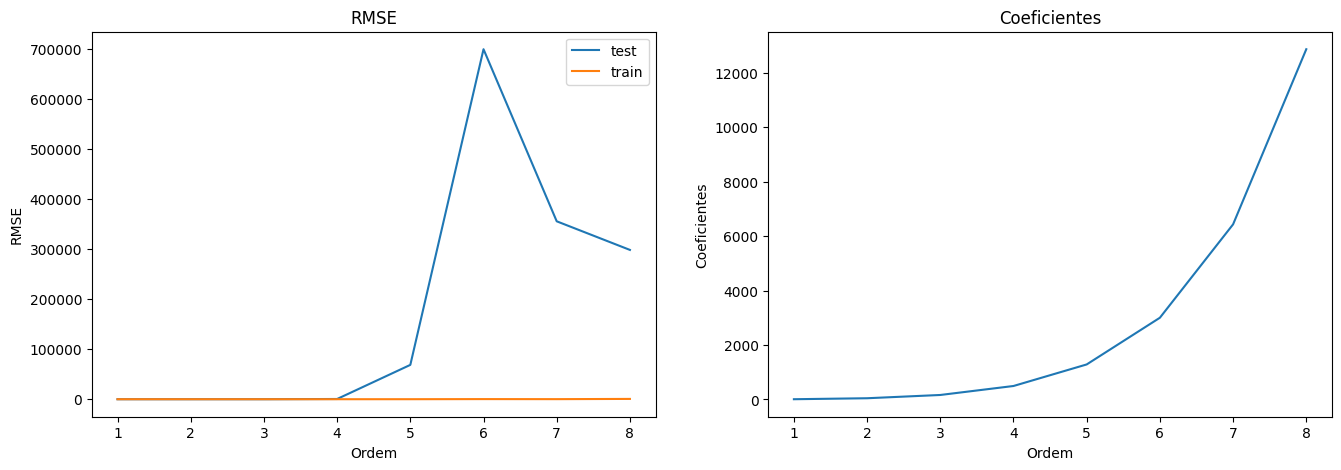

In [225]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = array_[np.where(sub['tipo'] == 'train')][:, 1]

RMSE_train = array_[np.where(sub['tipo'] == 'train')][:, 0]
RMSE_test = array_[np.where(sub['tipo'] == 'test')][:, 0]

ax[0].plot(x,RMSE_test, label='test')
ax[0].plot(x,RMSE_train, label='train')
ax[0].set_xticks(x)
ax[0].set_title('RMSE')
ax[0].legend()
ax[0].set_xlabel('Ordem')
ax[0].set_ylabel('RMSE')



coeficientes_train = array_[np.where(sub['tipo'] == 'train')][:, 2]

ax[1].plot(x,coeficientes_train)
ax[1].set_xticks(x)
ax[1].set_title('Coeficientes')
ax[1].set_xlabel('Ordem')
ax[1].set_ylabel('Coeficientes')

plt.show()

d. Repita os 2 itens anteriores incluindo um termo de regularização L2 (por exemplo, com fator λ = 0.01).

`SGD`

In [226]:
inicio = time.time()

with open('result_sgd.txt', 'w') as f:
    for i in range(1, 6+1):
        xtrain_p = polinomial(xtrain, i)

        xtest_p = polinomial(xtest, i)
        ols = RegressaoLinearSGD(
            x = xtrain_p,
            y = ytrain,
            regularizao = 'l2',
            alpha = 0.01,
            lr = 0.01,
            epochs = 1_0,
            salvar_processo = False,
            loss = RMSE
            )
        ols.ajusta()

        pred_test   = ols.predicao(xtest_p)
        pred_train  = ols.predicao(xtrain_p)

        inv_ytest = saida_ss.inversa_transformacao(ytest)
        inv_ytrain = saida_ss.inversa_transformacao(ytrain)

        inv_pred_test = saida_ss.inversa_transformacao(pred_test)
        inv_pred_train = saida_ss.inversa_transformacao(pred_train)

        RMSE_test = RMSE(inv_ytest, inv_pred_test)
        RMSE_train = RMSE(inv_ytrain, inv_pred_train)

        len_coef = len(ols.params)
        f.write(
            'test,' +str(round(RMSE_test,3)) +','+str(i)+','+str(len_coef)+'\n'
        )
        f.write(
            'train,'+str(round(RMSE_train,3)) +','+str(i)+','+str(len_coef)+'\n'
        )

final = time.time()
print(f'Tempo de execução: {final - inicio}')

0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.0185942197921625
Total time elapsed: 00:00:00
0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.034491432421392
Total time elapsed: 00:00:00
0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.0755841748497392
Total time elapsed: 00:00:00
0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.018897689659492
Total time elapsed: 00:00:00
0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.35341413330537
Total time elapsed: 00:00:00
0% [##########] 100% | ETA: 00:00:00 | Item ID: Epoca 10 - perda 1.0201948334704698

Tempo de execução: 1.5710785388946533



Total time elapsed: 00:00:00


In [227]:
# Definindo o tipo de cada coluna para leitura no numpy
dtypes = np.dtype([
    ('tipo', 'U5'),
    ('rmse', np.float32),
    ('ordem', np.int32),
    ('coeficientes', np.int32)
])

In [228]:
sub = np.loadtxt('result_sgd.txt', delimiter=',', dtype=dtypes)

In [229]:
array_ = np.column_stack([sub['rmse'], sub['ordem'], sub['coeficientes']])

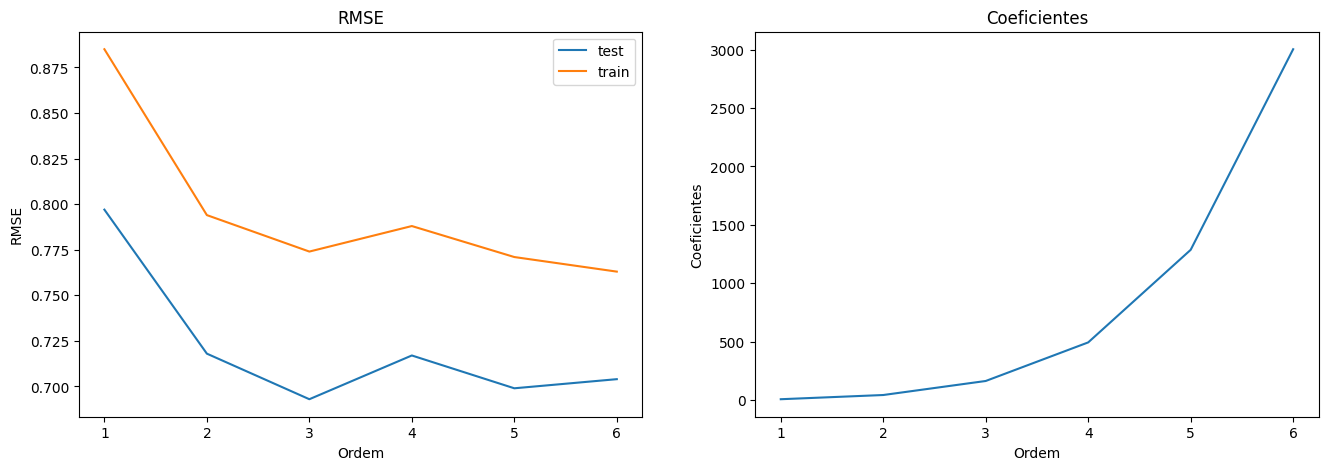

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = array_[np.where(sub['tipo'] == 'train')][:, 1]

RMSE_train = array_[np.where(sub['tipo'] == 'train')][:, 0]
RMSE_test = array_[np.where(sub['tipo'] == 'test')][:, 0]

ax[0].plot(x,RMSE_test, label='test')
ax[0].plot(x,RMSE_train, label='train')
ax[0].set_xticks(x)
ax[0].set_title('RMSE')
ax[0].legend()
ax[0].set_xlabel('Ordem')
ax[0].set_ylabel('RMSE')



coeficientes_train = array_[np.where(sub['tipo'] == 'train')][:, 2]

ax[1].plot(x,coeficientes_train)
ax[1].set_xticks(x)
ax[1].set_title('Coeficientes')
ax[1].set_xlabel('Ordem')
ax[1].set_ylabel('Coeficientes')

plt.show()

`GD`

In [231]:
inicio = time.time()
with open('result_gd.txt', 'w') as f:
    for i in range(1, 11+1):
        xtrain_p = polinomial(xtrain, i)

        xtest_p = polinomial(xtest, i)
        ols = RegressaoLinearGD(
            x = xtrain_p,
            y = ytrain,
            regularizao = 'l2',
            alpha = 0.01,
            lr = 0.01,
            epochs = 1_00,
            salvar_processo = False,
            loss = RMSE
            )
        ols.ajusta()

        pred_test   = ols.predicao(xtest_p)
        pred_train  = ols.predicao(xtrain_p)

        inv_ytest = saida_ss.inversa_transformacao(ytest)
        inv_ytrain = saida_ss.inversa_transformacao(ytrain)

        inv_pred_test = saida_ss.inversa_transformacao(pred_test)
        inv_pred_train = saida_ss.inversa_transformacao(pred_train)

        RMSE_test = RMSE(inv_ytest, inv_pred_test)
        RMSE_train = RMSE(inv_ytrain, inv_pred_train)

        len_coef = len(ols.params)
        f.write(
            'test,' +str(round(RMSE_test,3)) +','+str(i)+','+str(len_coef)+'\n'
        )
        f.write(
            'train,'+str(round(RMSE_train,3)) +','+str(i)+','+str(len_coef)+'\n'
        )

final = time.time()
print(f'Tempo de execução: {final - inicio}')

0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 1.0709629221479584
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 0.9322815339160909
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 1.5161436332558078
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 0.9732263890411641
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 1.330563551018054
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 1.450046703637105
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epoca 100 - perda 1.2005660722542515
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00 | Item 

Tempo de execução: 30.002469301223755


In [232]:
sub = np.loadtxt('result_gd.txt', delimiter=',', dtype=dtypes)

In [233]:
array_ = np.column_stack([sub['rmse'], sub['ordem'], sub['coeficientes']])

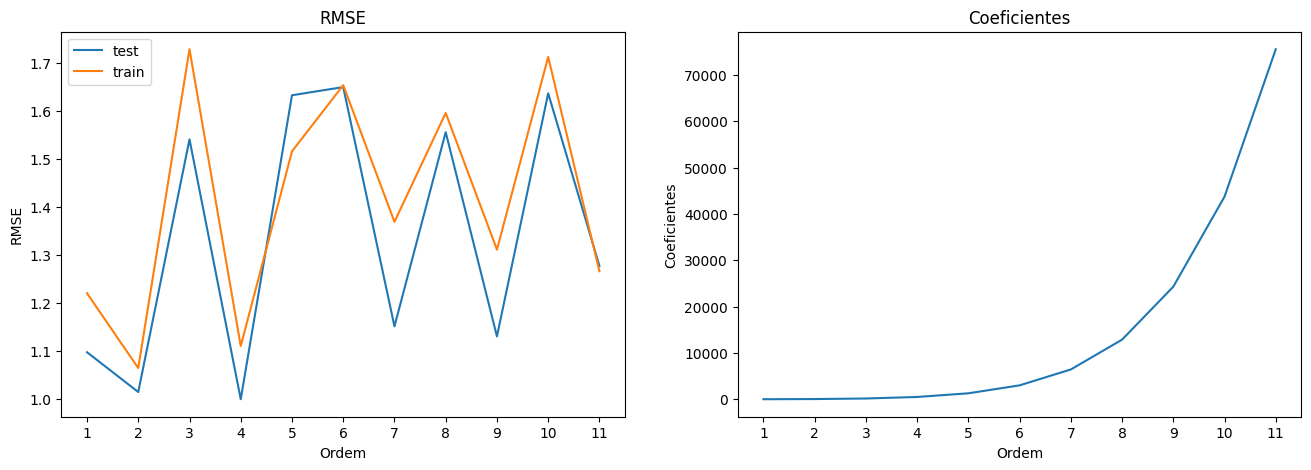

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

x = array_[np.where(sub['tipo'] == 'train')][:, 1]

RMSE_train = array_[np.where(sub['tipo'] == 'train')][:, 0]
RMSE_test = array_[np.where(sub['tipo'] == 'test')][:, 0]

ax[0].plot(x,RMSE_test, label='test')
ax[0].plot(x,RMSE_train, label='train')
ax[0].set_xticks(x)
ax[0].set_title('RMSE')
ax[0].legend()
ax[0].set_xlabel('Ordem')
ax[0].set_ylabel('RMSE')



coeficientes_train = array_[np.where(sub['tipo'] == 'train')][:, 2]

ax[1].plot(x,coeficientes_train)
ax[1].set_xticks(x)
ax[1].set_title('Coeficientes')
ax[1].set_xlabel('Ordem')
ax[1].set_ylabel('Coeficientes')

plt.show()

> Estava demonrando/ Estouro de memoria. Dessa Forma foram escolhidos poucos numeros de coeficientes.